In this task, you are provided with a set of train images that consist of icons
of objects. The set of icons in the training image are provided as shown in
figure 2. In this task you will implement algorithms for matching images,
similar to the principle of playing Dobble.

Output: Detect objects in the Test images, recognize to which class (from
the 50 Training image classes) they belong, and identify their bounding boxes.
One example of a test image is provided in figure 3. For visually demonstrating this, the function should open a box around each detected object and
indicate its class label. Demonstrate example images(s) of the outcome detection in your report.

Evaluate your algorithm on all Test images and report the overall False
Positive (FPR), True Positive (TPR) and accuracy (ACC) rates, and the
4
average runtime. Show and explain cases where this scheme finds difficulty to
perform correctly. Give insight about the complexity (memory and runtime)
of your algorithm in terms of the problem size e.g. how does the complexity
scale in terms of the number of image pixels, pyramid scales?

Creating scaled templates: You should create a Gaussian pyramid of
appropriate scale levels for each RGB Training image. This task includes
implementing appropriate Gaussian blurs and subsampling of the training
images through a hierarchy. You may use your own convolution algorithm
to apply the Gaussian blur, or you may use the library function. In your
report please explain the steps you take to build your Gaussian pyramids
and visually demonstrate an example pyramid for a Training image.

After creating scaled templates, you should append this set by creating
Gaussian pyramids for an appropriate number of orientations per class. This
creates the overall scaled and rotated templates. Justify your choice of parameters (e.g. Gaussian kernel specs, initial/final scales, number of scale
levels e.g. how many octaves, number of rotations etc). To justify quantitatively the chosen number of scales, plot or tabulate the overall object detection performance against these parameters and pick parameters that achieve
a reasonably good runtime vs. accuracy trade off. Evaluate your algorithm
on all Test images to report the overall Intersection over Union (IoU), False
Positive (FPR), True Positive (TPR) and Accuracy (ACC) rates, as well as
the average runtime. Refer to the following report http://host.robots.
ox.ac.uk/pascal/VOC/voc2012/devkit_doc.pdf section 4.4 for further information about the evaluation metrics.

Pre-processing: For each (scaled) template set the background to zero,
similarly for the Test data. Intensity-based matching (related to output 2):
Slide each (scaled and rotated) template over the Test image to measure
their similarities across x-y axes. An intensity-based similarity score based
matching function. Explain why this function is suitable to measure image
similarities? Define appropriate thresholds on this similarity score, a proper
non-maxima suppression strategy to avoid false positives within the neighbourhood of the detected objects and return the output in terms of class
label and bounding box: [left top right bottom] for each object.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from pathlib import Path
from copy import copy
import task2

In [1]:
templates = task2.template_pyramid_by_classname(Path("IconDataset", "png"))
(classname, template_pyr) = next(templates)
for i, layer in enumerate(template_pyr):
    # plt.imshow(cv2.cvtColor(layer, cv2.COLOR_GRAY2RGB)), plt.title(f"{classname} | layer {i}"), plt.show()

SyntaxError: incomplete input (2979043150.py, line 4)

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['06-church', '08-courthouse', '27-gas-station', '34-billboard', '35-police', '37-post-office', '45-museum', '50-cemetery']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


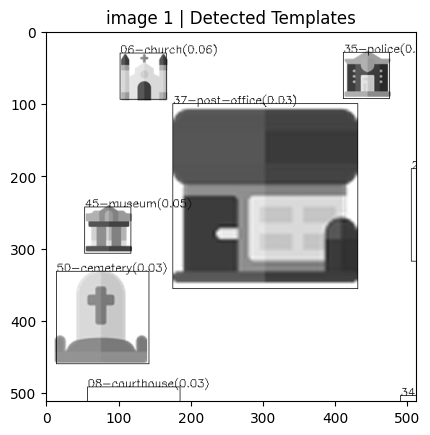

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['03-bridge-1', '20-atm', '27-gas-station', '50-cemetery']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


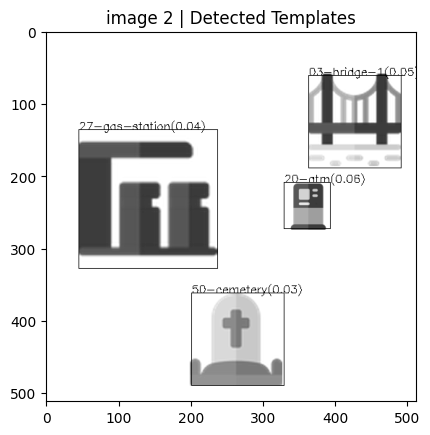

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['05-silo', '10-bench', '19-prison', '31-field', '50-cemetery']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


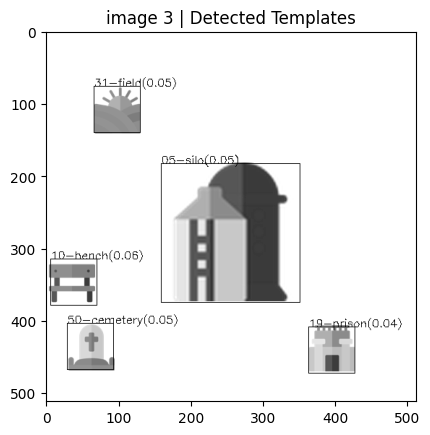

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['01-lighthouse', '03-bridge-1', '21-solar-panel']
Accuracy: 0.75
True positive rate: 0.75
False positive rate: 0.0
False negative rate: 0.25 


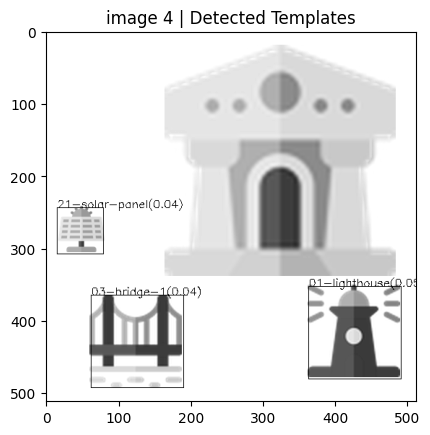

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['08-courthouse', '10-bench', '33-hydrant', '43-sign']
Accuracy: 0.75
True positive rate: 0.75
False positive rate: 0.0
False negative rate: 0.25 


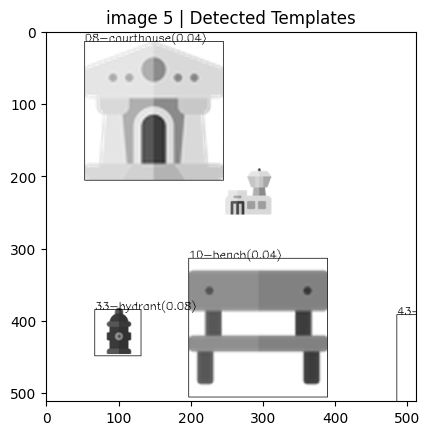

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['10-bench', '11-trash', '20-atm', '25-factory']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


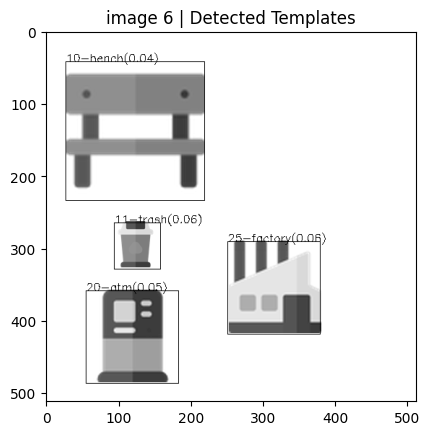

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['06-church', '27-gas-station', '28-government', '29-theater', '37-post-office', '41-windmill']
Accuracy: 0.6
True positive rate: 0.6
False positive rate: 0.0
False negative rate: 0.4 


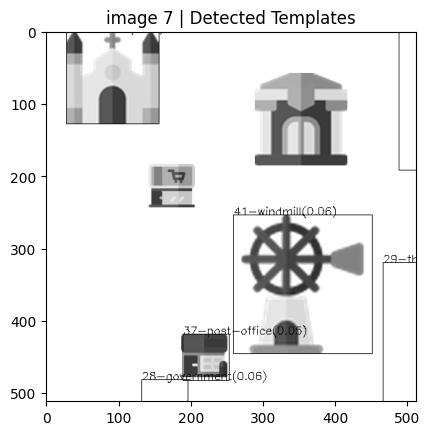

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['01-lighthouse', '05-silo', '28-government', '42-tractor', '45-museum']
Accuracy: 0.75
True positive rate: 0.75
False positive rate: 0.0
False negative rate: 0.25 


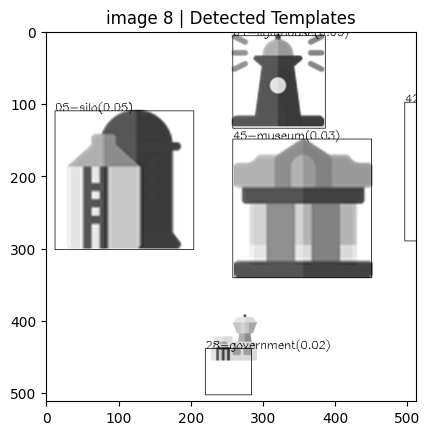

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['07-supermarket', '27-gas-station', '31-field', '34-billboard']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


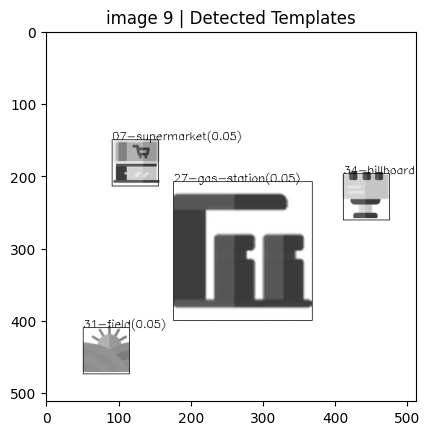

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['08-courthouse', '12-bus', '26-shop', '29-theater']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


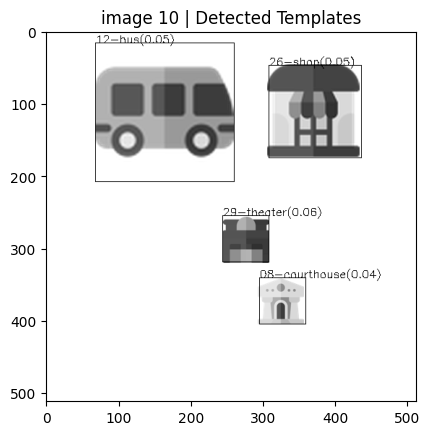

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['06-church', '24-fountain', '42-tractor', '47-restaurant']
Accuracy: 0.8
True positive rate: 0.8
False positive rate: 0.0
False negative rate: 0.2 


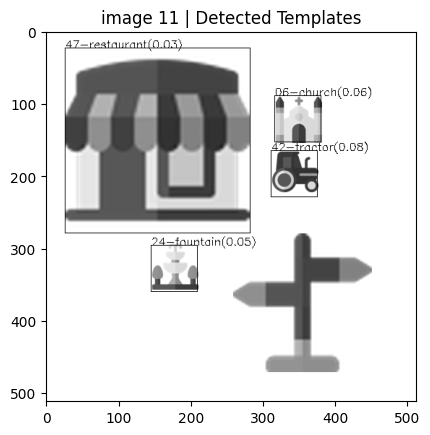

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['04-bridge', '07-supermarket', '28-government', '32-van', '46-fire-station']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


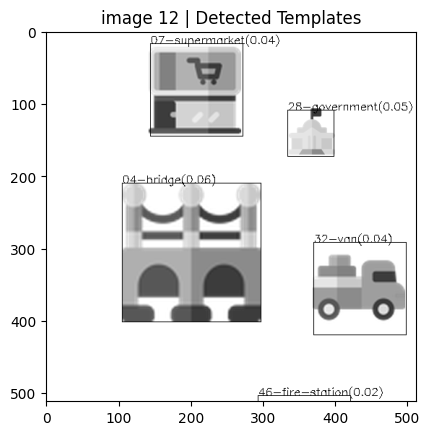

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['10-bench', '24-fountain', '27-gas-station', '36-hotel', '42-tractor']
Accuracy: 0.8
True positive rate: 0.8
False positive rate: 0.0
False negative rate: 0.2 


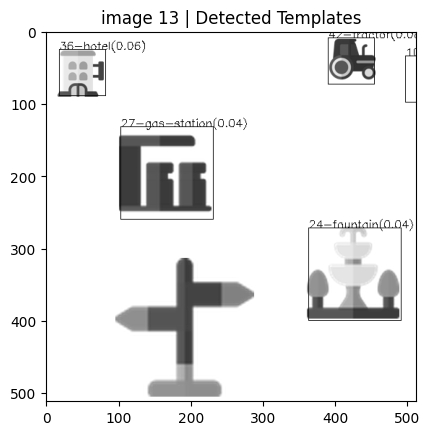

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['03-bridge-1', '06-church', '46-fire-station', '49-school']
Accuracy: 0.75
True positive rate: 0.75
False positive rate: 0.0
False negative rate: 0.25 


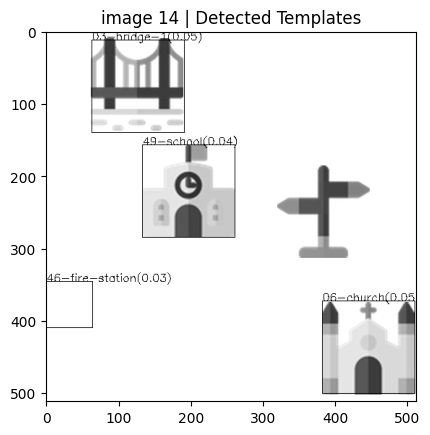

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['07-supermarket', '25-factory', '43-sign', '44-ferris-wheel', '47-restaurant']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


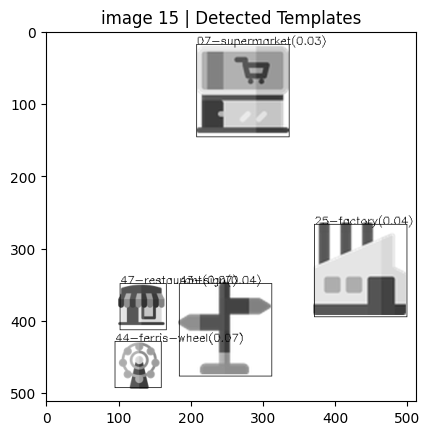

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['06-church', '11-trash', '28-government', '37-post-office', '42-tractor']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


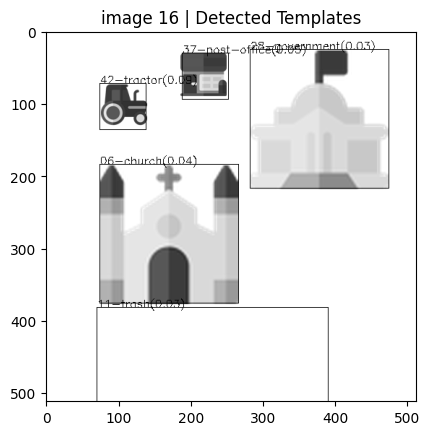

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['15-barn', '21-solar-panel', '33-hydrant', '34-billboard']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


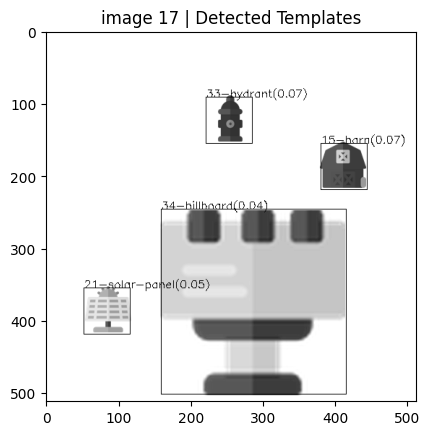

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['20-atm', '28-government', '35-police', '36-hotel']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


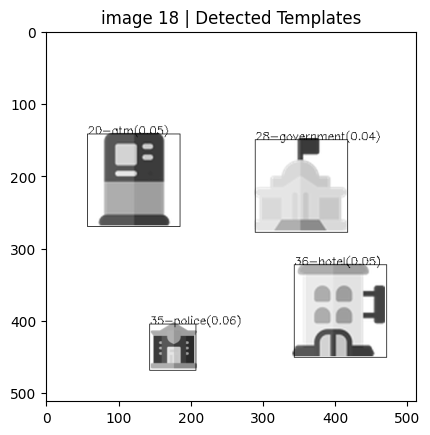

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['06-church', '08-courthouse', '12-bus', '27-gas-station', '44-ferris-wheel']
Accuracy: 0.75
True positive rate: 0.75
False positive rate: 0.0
False negative rate: 0.25 


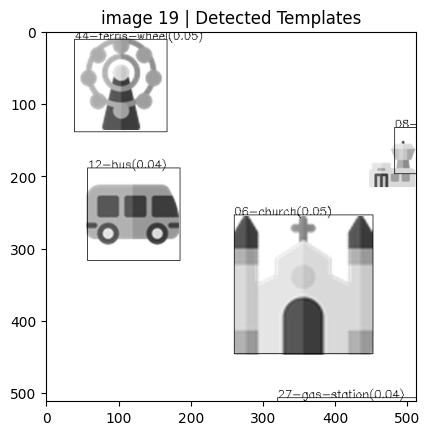

/home/jay/src/computer-vision/task2.py:195: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['03-bridge-1', '23-traffic-light', '27-gas-station', '43-sign', '46-fire-station']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


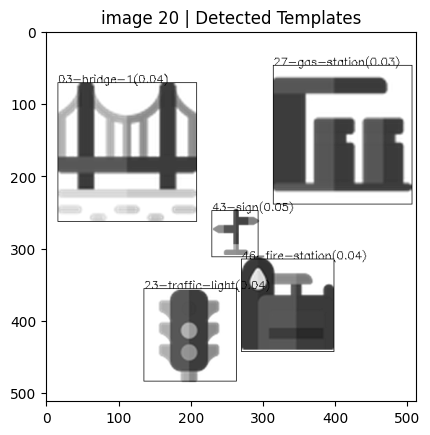

Averave accuracy: 0.8975
Average true positive rate: 0.8975
Average false positive rate: 0.0
Average false negative rate: 0.1025 


In [30]:

images = task2.images_with_annotations(Path("Task2Dataset"))
templates = task2.template_pyramid_by_classname(Path("IconDataset", "png"))
templates = [(classname, pyr) for (classname, pyr) in templates]

# plt.imshow(templates[0][1][0], cmap='gray')
# plt.title(f'template')
# plt.show()

results: list[tuple[float, float, float, float]] = []
template_metrics = {classname:np.array([0, 0, 0]) for (classname, _) in templates}
for i, (img, annotations) in enumerate(images):
    # img_pyr = task2.gaussian_pyrarmid(img, image_pyramid_levels)

    # image_grayscale = img#cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # _, image_binary = cv2.threshold(image_grayscale, 254, 255, cv2.THRESH_BINARY)
    # mask = cv2.bitwise_not(image_binary)
    # print(img.shape, mask.shape)
    # image_masked = cv2.bitwise_and(img, mask)
    # img = image_masked
    # plt.imshow(image_masked, cmap='gray'), plt.show()

    img_pyr = [cv2.GaussianBlur(img, ksize=(5,5), sigmaX=7)]
    classnames, scores, pred_boxes = task2.predict_all_templates(img_pyr, templates)

    task2.non_max_suppression(pred_boxes, scores, classnames)
    task2.annotate_predictions(img, classnames, scores, pred_boxes)
    metrics = task2.evaluation_metrics(dict(zip(classnames, pred_boxes)), annotations, template_metrics)
    results.append(metrics)

    accuracy, true_pos_rate, false_pos_rate, false_neg_rate = metrics
    print(f"Matches: {classnames}")
    print(f"Accuracy: {accuracy}")
    print(f"True positive rate: {true_pos_rate}")
    print(f"False positive rate: {false_pos_rate}")
    print(f"False negative rate: {false_neg_rate} ")
    
    plt.imshow(img, cmap='gray')
    plt.title(f'image {i+1} | Detected Templates')
    plt.show()

average_metrics = [np.mean(values) for values in zip(*results)]
print(f"Averave accuracy: {average_metrics[0]}")
print(f"Average true positive rate: {average_metrics[1]}")
print(f"Average false positive rate: {average_metrics[2]}")
print(f"Average false negative rate: {average_metrics[3]} ")

1x1  s=5
Averave accuracy: 0.7925
Average true positive rate: 0.805
Average false positive rate: 0.025
Average false negative rate: 0.195 

5x5  s=3
Averave accuracy: 0.8625
Average true positive rate: 0.885
Average false positive rate: 0.05
Average false negative rate: 0.11499999999999999 

gaussian
5x5  s=5
Averave accuracy: 0.8975
Average true positive rate: 0.915
Average false positive rate: 0.041666666666666664
Average false negative rate: 0.08499999999999999 

5x5  s=7
Averave accuracy: 0.8975
Average true positive rate: 0.8975
Average false positive rate: 0.0
Average false negative rate: 0.1025 

kernel=5x5 sigma=10
Averave accuracy: 0.8625
Average true positive rate: 0.8699999999999999
Average false positive rate: 0.016666666666666666
Average false negative rate: 0.13 

9x9  s=10
Averave accuracy: 0.7125
Average true positive rate: 0.7125
Average false positive rate: 0.01
Average false negative rate: 0.2875 

15x15  s=10
Averave accuracy: 0.2925
Average true positive rate: 0.29666666666666663
Average false positive rate: 0.03916666666666667
Average false negative rate: 0.7033333333333334 

15x15  s=15
Averave accuracy: 0.3275
Average true positive rate: 0.3275
Average false positive rate: 0.026666666666666665
Average false negative rate: 0.6725 

01-lighthouse | t_positives: 2; f_positives: 0, f_negatives: 0
01-lighthouse | acc: 1.0; true pos rate: 1.0; false pos rate 0.0; false neg rate 0.0
03-bridge-1 | t_positives: 3; f_positives: 0, f_negatives: 1
03-bridge-1 | acc: 0.75; true pos rate: 0.75; false pos rate 0.0; false neg rate 0.25
04-bridge | t_positives: 1; f_positives: 0, f_negatives: 0
04-bridge | acc: 1.0; true pos rate: 1.0; false pos rate 0.0; false neg rate 0.0
05-silo | t_positives: 2; f_positives: 0, f_negatives: 0
05-silo | acc: 1.0; true pos rate: 1.0; false pos rate 0.0; false neg rate 0.0
06-church | t_positives: 6; f_positives: 0, f_negatives: 0
06-church | acc: 1.0; true pos rate: 1.0; false pos rate 0.0; false neg rate 0.0
07-supermarket | t_positives: 4; f_positives: 0, f_negatives: 0
07-supermarket | acc: 1.0; true pos rate: 1.0; false pos rate 0.0; false neg rate 0.0
08-courthouse | t_positives: 1; f_positives: 0, f_negatives: 2
08-courthouse | acc: 0.3333333333333333; true pos rate: 0.3333333333333333; 

<Axes: xlabel='classname'>

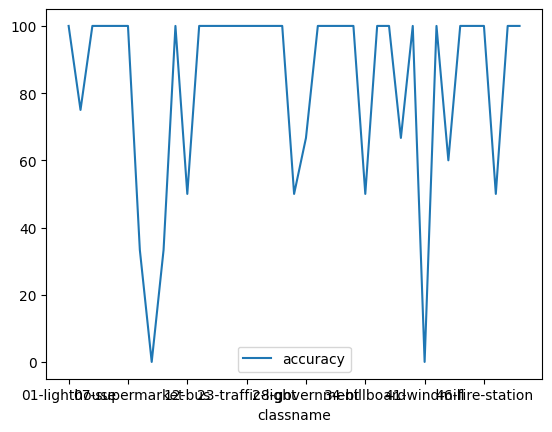

In [ ]:
images = task2.images_with_annotations(Path("Task2Dataset"))
all_annotaitons = [annotations for (_, annotations) in images]
occurences = {}
total_number_of_templates = 0 
for image_annotations in all_annotaitons:
    for classname, _ in image_annotations:
        if classname not in occurences:
            occurences[classname] = 1
        else:
            occurences[classname] += 1
        total_number_of_templates +=1

classnames = np.array(list(template_metrics.keys()))
true_positives = np.zeros(classnames.shape)
false_positives = np.zeros(classnames.shape)
false_negatives = np.zeros(classnames.shape)

template_accuracies = np.zeros(classnames.shape)
true_positive_rate = np.zeros(classnames.shape)
false_positive_rate = np.zeros(classnames.shape)
false_negative_rate = np.zeros(classnames.shape)

for i, (classname, t_m) in enumerate(template_metrics.items()):
    if classname in occurences:
        tps, fps, fns = t_m[0], t_m[1], t_m[2]
        true_positives[i] = tps
        false_positives[i] = fps
        false_negatives[i] = fns

        print(f"{classname} | t_positives: {tps}; f_positives: {fps}, f_negatives: {fns}")
        accuracy = tps / occurences[classname]
        tpr = tps / (tps + fns)
        fpr = fps / (fps + total_number_of_templates - tps)
        fnr = fns / (fns + tps)

        template_accuracies[i] = accuracy * 100
        true_positive_rate[i] = tpr * 100
        false_positive_rate[i] = fpr * 100
        false_negative_rate[i] = fnr * 100

        print(f"{classname} | acc: {accuracy}; true pos rate: {tpr}; false pos rate {fpr}; false neg rate {fnr}")
    
print(classnames)
# write to csv
columns = ["classname", "# true positives", "# false positives", "# false negatives"]
data = [[classname, tp, fp, fn]
        for (classname, tp, fp, fn) in zip(classnames, true_positives, false_positives, false_negatives) if classname in occurences]
template_classifications = pd.DataFrame(data=data, columns=columns)
template_classifications.to_csv("task2-evaluation/classifications-per-template.csv")

columns = ["classname", "accuracy", "true positive rate", "false positive rate", "false negative rate"]
data = [[classname, accuracy, tpr, fpr, fnr] 
        for (classname, accuracy, tpr, fpr, fnr) in 
        zip(classnames, template_accuracies, true_positive_rate, false_positive_rate, false_negative_rate)
        if classname in occurences]
template_metrics_df = pd.DataFrame(data=data, columns=columns)
template_metrics_df.to_csv("task2-evaluation/metrics-per-template.csv")
# template_metrics_df.plot(x="classname", y=["accuracy", "true positive rate", "false positive rate", "false negative rate"])
template_metrics_df.plot(x="classname", y="accuracy")
# pd.DataFrame(dataframe, columns=columns).to_csv("metrics-per-template.csv")

In [15]:

def add_gaussian_noise(image, mean, sigma):
    """Add Gaussian noise to the image."""
    gauss = np.random.normal(mean, sigma, image.shape)
    noisy_image = np.clip(image + gauss, 0, 255).astype(np.uint8)
    return noisy_image

images = task2.images_with_annotations(Path("Task2Dataset"))
for i, (img, _) in enumerate(images):
    noise_image = add_gaussian_noise(img, mean=0, sigma=10)
    cv2.imwrite(f"./Task2Dataset/noisy-images/test_image_{i+1}.png", noise_image)


In [28]:
images = task2.images_with_annotations(Path("Task2Dataset"))
for i, (img, _) in enumerate(images):
    # cv2.imwrite(f"./Task2Dataset/rotated-images/test_image_{i+1}_0.png", img)
    cv2.imwrite(f"./Task2Dataset/rotated-images/test_image_{i+1}_90.png", cv2.rotate(img.copy(),cv2.ROTATE_90_CLOCKWISE))
    cv2.imwrite(f"./Task2Dataset/rotated-images/test_image_{i+1}_180.png", cv2.rotate(img.copy(),cv2.ROTATE_180))
    cv2.imwrite(f"./Task2Dataset/rotated-images/test_image_{i+1}_270.png", cv2.rotate(img.copy(),cv2.ROTATE_90_COUNTERCLOCKWISE))

[0.8, 0.75, 1.0, 0.75, 0.25, 0.75, 0.8, 0.75, 1.0, 0.75, 0.6, 1.0, 0.8, 1.0, 1.0, 0.75, 0.75, 1.0, 0.75, 0.6]
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


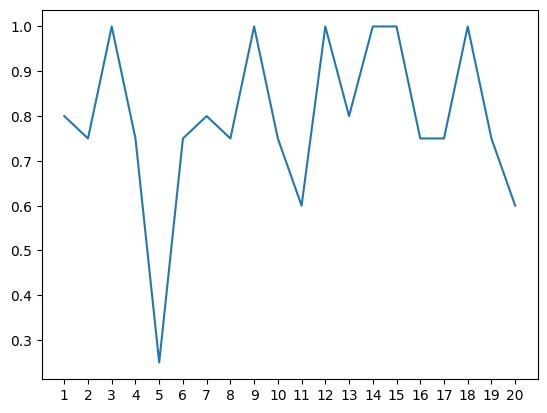

Averave accuracy: 0.7925
Average true positive rate: 0.805
Average false positive rate: 0.025
Average false negative rate: 0.195 


In [21]:
img_names = [f"{i + 1}" for i in range(20)]
accuracy, tpr, fpr, fnr = [list(t) for t in zip(*rotated_images)]
print(list(accuracy))
print(img_names)
plt.plot(img_names, accuracy), plt.show()

average_metrics = [np.mean(values) for values in zip(*rotated_images)]
print(f"Averave accuracy: {average_metrics[0]}")
print(f"Average true positive rate: {average_metrics[1]}")
print(f"Average false positive rate: {average_metrics[2]}")
print(f"Average false negative rate: {average_metrics[3]} ")

Averave accuracy: 0.605
Average true positive rate: 0.725
Average false positive rate: 0.2058333333333333
Average false negative rate: 0.27499999999999997 

opencv matchtemplate


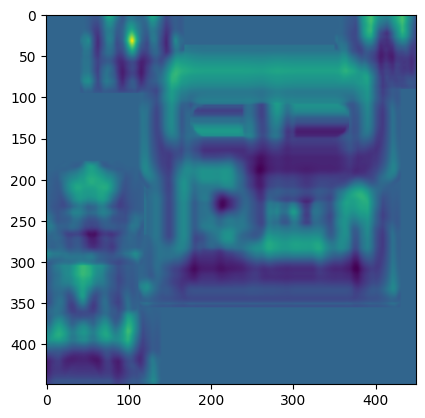

(-0.46739596128463745, 0.9660936594009399, (376, 308), (104, 32))
fft ccoef_normed
aaa (64, 64)
(2, 64)


/home/jay/src/computer-vision/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2486: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results = func(*(arg[index] for arg in args))


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'minMaxLoc'
> Overload resolution failed:
>  - src is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'src'


In [95]:
num_pyramid_levels = 5
images = task2.images_with_annotations(Path("Task2Dataset"))
templates = task2.template_pyramid_by_classname(Path("IconDataset", "png"))

img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# norm_image = (img - np.mean(img)) / np.std(img)
# plt.imshow(img), plt.show()    
# plt.imshow(norm_image), plt.show()    
    # norm_template = (template - np.mean(template)) / np.std(template)
# plt.imshow(img), plt.show()    
classname, pyr = next(templates)
while classname != "06-church":
    classname, pyr = next(templates)
template = pyr[16]
# plt.imshow(img), plt.show()
# plt.imshow(template), plt.show()

# print("template shape: ", template.shape)
# img_copy = img.copy()
# result_same_size_test = cv2.matchTemplate(img_copy, template, cv2.TM_SQDIFF) # <-- this is not allowed
# print(cv2.minMaxLoc(result_same_size_test))

# multi_scale_template_matching(img, template)

print("opencv matchtemplate")
result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED) # <-- this is not allowed
plt.imshow(result), plt.show()
print(cv2.minMaxLoc(result))

print("fft ccoef_normed")
result_home_grown = task2.normed_cross_correlation(img, template)
print(cv2.minMaxLoc(result_home_grown))
plt.imshow(result_home_grown), plt.show()

# annotated_img = img.copy()
# for (img, annotations) in images:
# task2.predict_all_templates(templates, img, annotations, annotated_img, num_pyramid_levels)
# plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_GRAY2RGB)), plt.show()    